# Benchmarking how pairing algorithm scales w.r.t time

In [1]:
import time
import torch
import relu_pairing
import matplotlib.pyplot as plt

In [11]:
def make_mat(M=2000, N=200):
    # print(f"Creating synthetic matrix of shape {M}x{N}...")

    # Generate M/2 unique base rows
    base_rows = torch.randint(0, 3, (M // 2, N), dtype=torch.long)

    # Check if base rows are unique by looking for duplicates
    _, counts = torch.unique(base_rows, dim=0, return_counts=True)
    if torch.any(counts > 1):
        raise ValueError(
            "Generated base rows contain duplicates - regenerating required"
        )

    # Create pairs by duplicating each row
    matrix = torch.zeros(M, N, dtype=torch.long)
    for i in range(M // 2):
        matrix[2 * i] = base_rows[i]
        matrix[2 * i + 1] = base_rows[i]

    # Shuffle to make it more challenging
    perm = torch.randperm(M)
    matrix = matrix[perm]
    return matrix

In [12]:
mats = [
    make_mat(M=i, N=200) for i in range(5000, 50000, 2000)
]

## Benchmarking on CPU

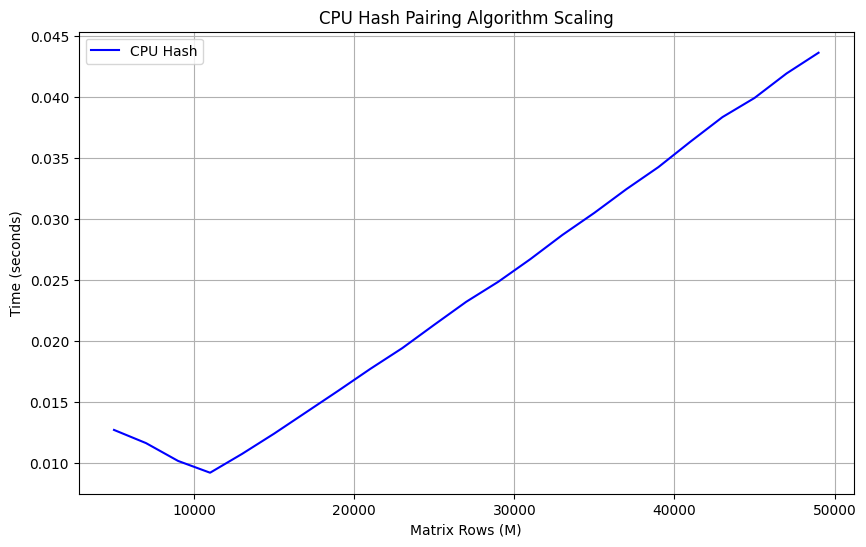

In [13]:
# Record CPU times
cpu_times = []

for mat in mats:
    mat = mat.cpu()
    start_time = time.time()
    pairs = relu_pairing.ops.hash_pair_rows(mat)
    cpu_time = time.time() - start_time
    cpu_times.append(cpu_time)
    # print(f"Matrix {mat.shape[0]}x{mat.shape[1]}: {cpu_time:.4f}s")

# Plot scaling curve

sizes = [mat.shape[0] for mat in mats]

plt.figure(figsize=(10,6))
plt.plot(sizes, cpu_times, 'b-', label='CPU Hash')
plt.xlabel('Matrix Rows (M)')
plt.ylabel('Time (seconds)')
plt.title('CPU Hash Pairing Algorithm Scaling')
plt.grid(True)
plt.legend()
plt.show()


## Benchmarking on GPU - hashing

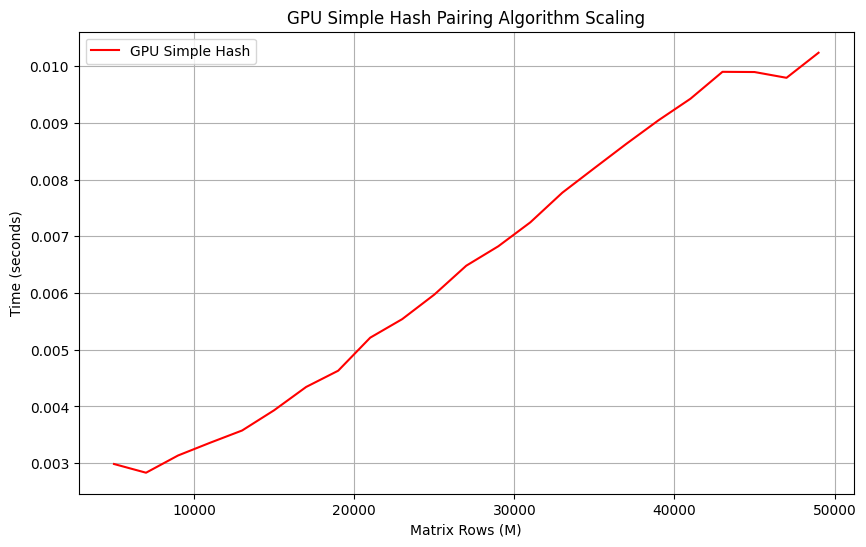

In [14]:
# Record GPU times
gpu_times = []

if torch.cuda.is_available():
    for mat in mats:
        mat = mat.cuda()
        start_time = time.time()
        pairs = relu_pairing.ops.hash_pair_rows_simple(mat) 
        gpu_time = time.time() - start_time
        gpu_times.append(gpu_time)
        
    # Plot scaling curve
    plt.figure(figsize=(10,6))
    plt.plot(sizes, gpu_times, 'r-', label='GPU Simple Hash')
    plt.xlabel('Matrix Rows (M)')
    plt.ylabel('Time (seconds)') 
    plt.title('GPU Simple Hash Pairing Algorithm Scaling')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("CUDA not available - skipping GPU benchmarks")


## Benchmarking on GPU - hashing and caching

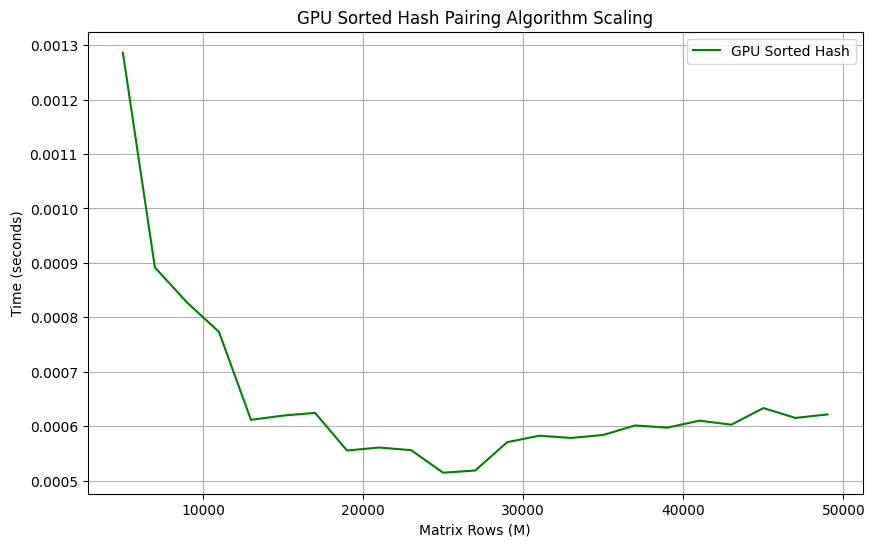

In [15]:
# Record GPU times for caching
gpu_cache_times = []

if torch.cuda.is_available():
    for mat in mats:
        mat = mat.cuda()
        start_time = time.time()
        pairs = relu_pairing.ops.hash_pair_rows_sorted(mat)
        gpu_time = time.time() - start_time
        gpu_cache_times.append(gpu_time)
        
    # Plot scaling curve
    plt.figure(figsize=(10,6))
    plt.plot(sizes, gpu_cache_times, 'g-', label='GPU Sorted Hash')
    plt.xlabel('Matrix Rows (M)')
    plt.ylabel('Time (seconds)')
    plt.title('GPU Sorted Hash Pairing Algorithm Scaling')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("CUDA not available - skipping GPU benchmarks")
